In [57]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


Phoneme — распознавание голоса (Andreas Buja, Werner Stuetzle and Martin Maechler)

$4509$ $\log$-периодограмм длины $d = 256$ (все признаки количественные).

«sh» as in «she»

«dcl» as in «dark»

«iy» as the vowel in «she»

«aa» as the vowel in «dark»

«ao» as the first vowel in «water»

In [3]:
#import urllib
#url = "http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/phoneme.data"
#raw_data = urllib.urlopen(url)
#X = np.loadtxt(raw_data, delimiter = ",", usecols = range(4)) # загрузка первых 4 столбцов
X = np.loadtxt('../source/phoneme.data', delimiter = ",", dtype = float, skiprows = 1, usecols = range(1, 257))
y = np.loadtxt('../source/phoneme.data', delimiter = ",", dtype = str, skiprows = 1, usecols = [257])
(N, d) = X.shape

In [4]:
print N, d

4509 256


In [12]:
y_names = np.unique(y)
print y_names
K = len(y_names)

['aa' 'ao' 'dcl' 'iy' 'sh']


In [13]:
print 'Phoneme  Count'
for i in range(K):
    print '  %3s    %4s' % (y_names[i], np.count_nonzero(y == y_names[i]))

Phoneme  Count
   aa     695
   ao    1022
  dcl     757
   iy    1163
   sh     872


In [14]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5)
N_test, _ = X_test.shape

In [26]:
from sklearn.svm import SVC
svc = SVC(kernel = 'linear')
svc.fit(X_train, y_train)
y_train_pred = svc.predict(X_train)
y_test_pred  = svc.predict(X_test)
print np.mean(y_train_pred != y_train)
print np.mean(y_test_pred  != y_test)

0.0291100637649
0.10421286031


In [28]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca.fit(X_test, y_test)
X_pca = pca.transform(X_train)

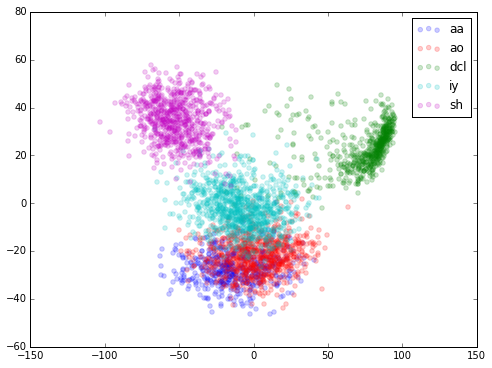

In [29]:
colors = ['b', 'r', 'g', 'c', 'm']
plt.figure(figsize = (8, 6))
for i in range(5):
    plt.scatter(X_pca[y_train == y_names[i], 0], X_pca[y_train == y_names[i], 1], 
                color = colors[i], label = y_names[i], alpha = 0.2)
plt.legend();

In [25]:
# Выполняется достаточно долго
print 'n components', 'train error', 'test error'
for n_comp in [1, 5, 10, 15, 20, 25, d]:
    pca = PCA(n_components = n_comp)
    pca.fit(X_train, y_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca  = pca.transform(X_test)
    svc = SVC(kernel = 'linear') # Здесь можно использовать любой другой классификатор
    svc.fit(X_train_pca, y_train)   
    y_train_pred = svc.predict(X_train_pca)
    y_test_pred  = svc.predict(X_test_pca)
    print '      %3d        %7.4f    %7.4f' % (n_comp, np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred))

n components train error test error
       1         0.3967     0.4324
       5         0.0984     0.1098
      10         0.0685     0.0798
      15         0.0671     0.0820
      20         0.0607     0.0865
      256         0.0299     0.1053


In [50]:
# То же самое (но CV) с использованием Pipeline и grid_search:
# Выполняется достаточно долго
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

pipeline = Pipeline(steps = [('pca', PCA()), ('svc', SVC(kernel = 'linear'))])

n_components = [1, 5, 10, 15, 20, 25, d]
grid_search = GridSearchCV(pipeline, dict(pca__n_components = n_components))
grid_search.fit(X_train, y_train)

GridSearchCV(cv=None,
       estimator=Pipeline(steps=[('pca', PCA(copy=True, n_components=None, whiten=False)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'pca__n_components': [1, 5, 10, 15, 20, 25, 256L]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [51]:
grid_search.grid_scores_

[mean: 0.60299, std: 0.00666, params: {'pca__n_components': 1},
 mean: 0.89576, std: 0.00547, params: {'pca__n_components': 5},
 mean: 0.92764, std: 0.00372, params: {'pca__n_components': 10},
 mean: 0.92653, std: 0.00724, params: {'pca__n_components': 15},
 mean: 0.92986, std: 0.00582, params: {'pca__n_components': 20},
 mean: 0.92847, std: 0.01078, params: {'pca__n_components': 25},
 mean: 0.89409, std: 0.01113, params: {'pca__n_components': 256L}]

In [52]:
1 - grid_search.best_score_

0.070141391738286707

In [53]:
grid_search.best_params_

{'pca__n_components': 20}

(0, 256L)

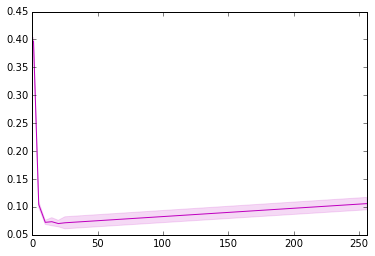

In [54]:
err_cv  = 1 - np.array([x[1] for x in grid_search.grid_scores_])
err_std = map(np.std, [x[2] for x in grid_search.grid_scores_])
plt.plot(n_components, err_cv, color = 'm')
plt.fill_between(n_components, err_cv - err_std, err_cv + err_std, alpha = 0.15, color = "m")
plt.xlim(0, d)    

In [56]:
y_test_predict = grid_search.best_estimator_.predict(X_test)
np.mean(y_test_predict != y_test)

0.086474501108647447